In [1]:
pip install -U skorch

In [2]:
import kagglehub
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

# Import dataset

In [3]:
# Read in data file
path = kagglehub.dataset_download("shubh0799/churn-modelling")
contents = os.listdir(path)

# Import data
for item in contents:
  if item.endswith('.csv'):
    data_file = os.path.join(path, item)

In [4]:
df = pd.read_csv(data_file)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data preprocessing

In [5]:
# Remove irrelevant column
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Check data shape
df.shape

(10000, 11)

In [7]:
# Check missing data
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [8]:
# Separate featuers and labels
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [9]:
# Train test split before further preprocessing to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(X_train.head())
print(y_train.head())

      CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
9254          686    France    Male   32       6       0.00              2   
1561          632   Germany    Male   42       4  119624.60              2   
1670          559     Spain    Male   24       3  114739.92              1   
6087          561    France  Female   27       9  135637.00              1   
6669          517    France    Male   56       9  142147.32              1   

      HasCrCard  IsActiveMember  EstimatedSalary  
9254          1               1        179093.26  
1561          1               1        195978.86  
1670          1               0         85891.02  
6087          1               0        153080.40  
6669          0               0         39488.04  
9254    0
1561    0
1670    1
6087    1
6669    1
Name: Exited, dtype: int64


In [10]:
# Define types of columns
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender']
binary_features = ['HasCrCard', 'IsActiveMember']

In [11]:
# Encode categorical columns and standardize numerical columns
preprocessor = ColumnTransformer(
    transformers =
        [('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features), # OneHotEncoder for nominal data
        ('bin', 'passthrough', binary_features)] # Pass binary features through without scaling
    , remainder='drop'
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
# Check processed columns
print(preprocessor.get_feature_names_out())

['num__CreditScore' 'num__Age' 'num__Tenure' 'num__Balance'
 'num__NumOfProducts' 'num__EstimatedSalary' 'cat__Geography_Germany'
 'cat__Geography_Spain' 'cat__Gender_Male' 'bin__HasCrCard'
 'bin__IsActiveMember']


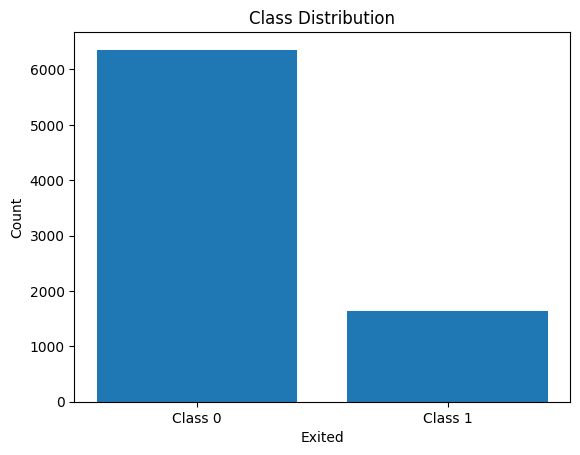

Exited
0    6356
1    1644
Name: count, dtype: int64


In [13]:
# Check for class imbalance
count_class = y_train.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 0', 'Class 1'])
plt.show()

print(count_class)

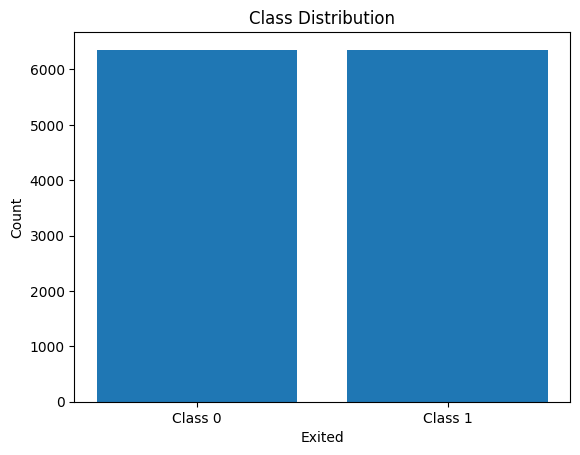

Exited
0    6356
1    6356
Name: count, dtype: int64


In [14]:
# Apply SMOTE to combat class imbalance
smote = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

count_class = y_train_smote.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 0', 'Class 1'])
plt.show()

print(count_class)

In [15]:
# Convert data to the correct type for PyTorch and skorch
X_train_smote = X_train_smote.astype('float32')
y_train_smote = y_train_smote.astype('float32').to_numpy().reshape(-1, 1)
X_test = X_test.astype('float32')
y_test = y_test.astype('float32').to_numpy().reshape(-1, 1)

# Neural Network Approach

Here, we are using a basic Pytorch Neural Network with 3 fully connected layer (fc1, fc2, fc3), which outputs the raw scores at the output layer.

We use GridSearchCV to determine the best performing combination of hyperparameters. Then we build model for testing using those hyperparameters.



In [16]:
# Define NN model
class Model(nn.Module):

  def __init__(self, in_features, h1=32, h2=16):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # Output raw scores (logits)
    return x

In [17]:
# Create the skorch NeuralNetClassifier wrapper
net = NeuralNetClassifier(
    module = Model,
    module__in_features = X_train_smote.shape[1], # Dynamically set input_dim
    criterion = nn.BCEWithLogitsLoss, # Numerically stable loss for binary classification
    optimizer = torch.optim.Adam,
    lr = 0.01,
    max_epochs = 10,
    batch_size = 32,
    verbose = 0,
    train_split = None # GridSearchCV will handle the CV splitting
)

In [18]:
# Define grid of hyperparameters to search
param_grid = {
    'lr': [0.005, 0.001],
    'max_epochs': [40, 60],
    'batch_size': [32, 64],
    'module__h1': [16, 64, 128],
    'module__h2': [8, 32, 64],
    'optimizer': [torch.optim.Adam, torch.optim.SGD]
}

In [19]:
# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator = net,
    param_grid = param_grid,
    cv = 3, # For faster execution
    scoring = 'recall', # Use Recall here to identify as many at-risk customers as possible to minimize lost revenue
    verbose = 2,
    n_jobs = -1 # Use all processors for parallel processing
)

In [20]:
# Start grid search
grid_search_result = grid_search.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


In [21]:
# Print results
print(f"\nBest Score (F1-Score): {grid_search_result.best_score_ * 100:.2f}%")
print(f"Best Parameters: {grid_search_result.best_params_}")


Best Score (F1-Score): 99.48%
Best Parameters: {'batch_size': 32, 'lr': 0.005, 'max_epochs': 40, 'module__h1': 128, 'module__h2': 64, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [22]:
# Create the model with the best hyperparameters settings
best_net = grid_search.best_estimator_

In [23]:
# Testing
y_pred_nn = best_net.predict(X_test)

# Print results (Will not use accuracy since it is a poor metric for churn prediction)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print(f'Precision score on test set with the best model: {precision_nn * 100:.2f}%')
print(f'Recall score on test set with the best model: {recall_nn * 100:.2f}%')
print(f'F1 score on test set with the best model: {f1_nn * 100:.2f}%')

Precision score on test set with the best model: 22.37%
Recall score on test set with the best model: 95.93%
F1 score on test set with the best model: 36.28%


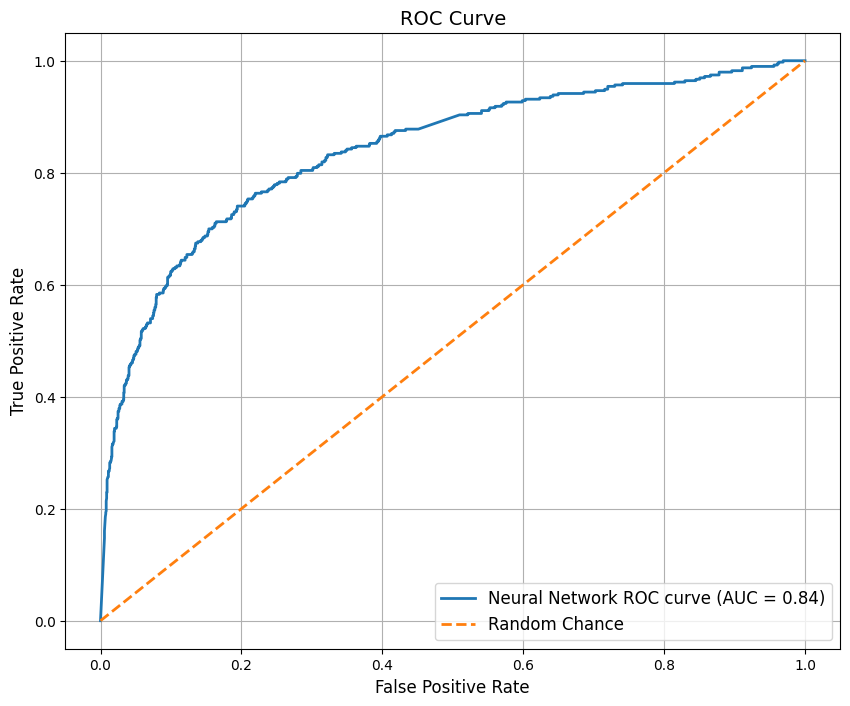

In [24]:
# Plot the AUC-ROC curve
y_pred_proba_nn = best_net.predict_proba(X_test)[:, 1]
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn)
auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_nn, tpr_nn, lw=2, label=f'Neural Network ROC curve (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# XGBoost Approach
An XGBoost model was developed as a performance benchmark against the neural network. This approach handles class imbalance directly by using the **scale_pos_weight** parameter, providing an alternative to the SMOTE methodology used for the neural network.

In [25]:
# Handle class imbalance with scale_pos_weight instead of SMOTE
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
spw = neg_count / pos_count
print(spw)

3.8661800486618003


In [26]:
# Instantiate XGBoost Model
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    scale_pos_weight = spw, # scale_pos_weight is used here
    n_estimators = 100,
    learning_rate = 0.001,
    max_depth = 5
)

In [27]:
# Training
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [28]:
# Testing
y_pred_xgb = xgb_classifier.predict(X_test)

# Print results
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f'Precision score for XGB model: {precision_xgb * 100:.2f}%')
print(f'Recall score for XGB model: {recall_xgb * 100:.2f}%')
print(f'F1 score for XGB model: {f1_xgb * 100:.2f}%')

Precision score for XGB model: 43.61%
Recall score for XGB model: 79.90%
F1 score for XGB model: 56.42%


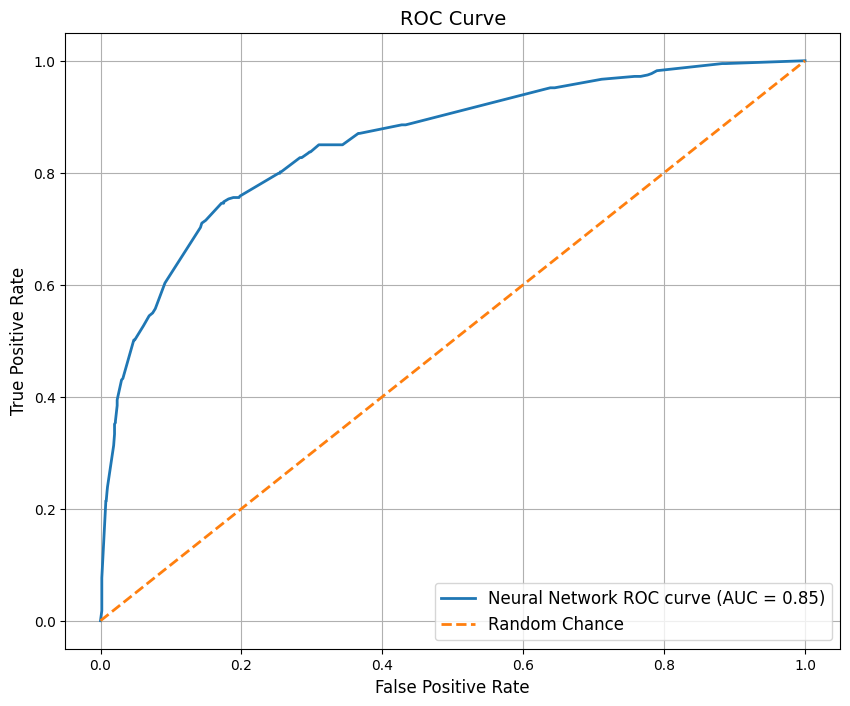

In [29]:
# Plot the AUC-ROC curve
y_pred_proba_xgb = xgb_classifier.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'Neural Network ROC curve (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

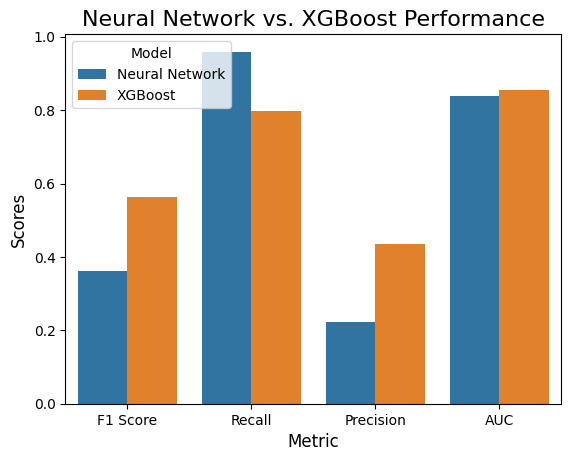

In [33]:
# Side by side barplot
data_to_plot = {
    'Metric': ['F1 Score', 'Recall', 'Precision', 'AUC', 'F1 Score', 'Recall', 'Precision', 'AUC'],
    'Score': [f1_nn, recall_nn, precision_nn, auc_nn, f1_xgb, recall_xgb, precision_xgb, auc_xgb],
    'Model': ['Neural Network', 'Neural Network', 'Neural Network', 'Neural Network', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost']
}
plot_df = pd.DataFrame(data_to_plot)

#plt.figure(figsize=(10, 7))
x = sns.barplot(data=plot_df, x='Metric', y='Score', hue='Model')
plt.title('Neural Network vs. XGBoost Performance', fontsize=16)
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Scores', fontsize=12)

plt.show()